In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, "/scratch/ar7420/VINN/Detic/third_party/CenterNet2/")
sys.path.insert(0, "/scratch/ar7420/VINN/Detic/")
# sys.path.insert(0,'third_party/CenterNet2/')
# sys.path.insert(0,'/home/irmak/Workspace/Detic/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [2]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/ext3/py3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [4]:
print(type(im))

NameError: name 'im' is not defined

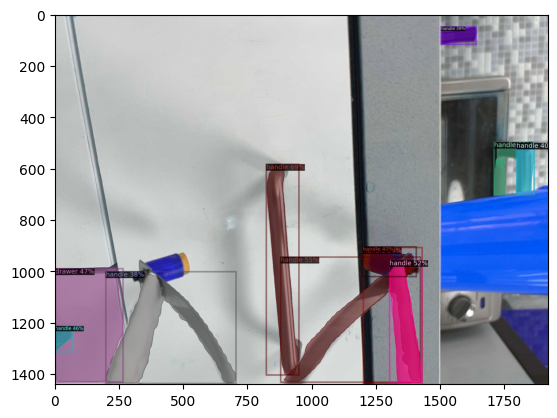

In [16]:
plt.imshow(im)

--2023-04-21 21:22:22--  https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289506 (283K) [image/jpeg]
Saving to: 'desk.jpg.11'

desk.jpg.11         100%[===================>] 282.72K  --.-KB/s    in 0.1s    

2023-04-21 21:22:22 (2.66 MB/s) - 'desk.jpg.11' saved [289506/289506]



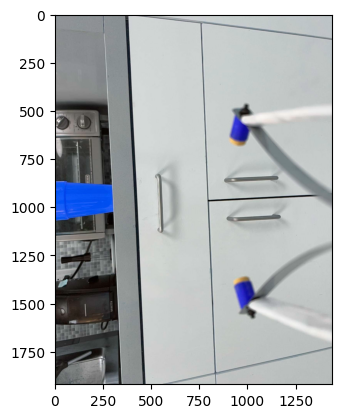

In [7]:
!wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
im = cv2.imread("/scratch/ar7420/VINN/clip-policy/data/2023-04-21--14-23-28_0/images/0001.jpg")
plt.imshow(np.rot90(im))


In [11]:
im = np.rot90(im)

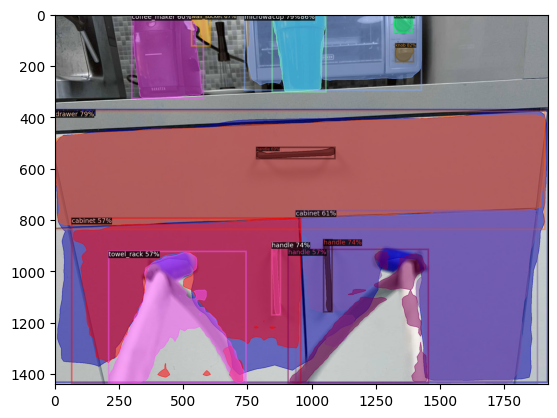

In [8]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [26]:
# print(outputs)
# print(outputs.keys()) # dict_keys(['instances']) 
# print(outputs['instances']) # Instances(num_instances=29, image_height=960, image_width=1280, fields=[pred_boxes: Boxes(tensor([[5.6106e+01, 4.0452e+02, 3.5595e+02, 6.5933e+02],
# print(outputs['instances'][0]) # instances gives each box and this gives:
'''
Instances(num_instances=1,
image_height=960, image_width=1280,
fields=[pred_boxes:
Boxes(tensor([[ 56.1057, 404.5162, 355.9506, 659.3253]],
device='cuda:0')),
 scores: tensor([0.9645], device='cuda:0'),
 pred_classes: tensor([630], device='cuda:0'), pred_masks:
'''

# print(outputs['instances'][0].keys())
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/instances.html gives info
fields = outputs['instances'].get_fields()
fields.keys() # dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks']) 
fields['scores'] # Gives every score for each predicted class

tensor([0.8103, 0.6857, 0.6017, 0.5976, 0.5916, 0.5861, 0.5501, 0.5410, 0.5154,
        0.5074, 0.5039], device='cuda:0')

In [14]:
from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    print('texts: {}'.format(texts))
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb
  
vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")
metadata.thing_classes = ['microwave', 'handle', 'cabinet', 'cup'] # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.15
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

Loading pretrained CLIP
texts: ['a microwave', 'a handle', 'a cabinet', 'a cup']


In [28]:
print(classifier.shape) # torch.Size([512, 4]) - each class 

torch.Size([512, 4])


(1920, 1440, 3)


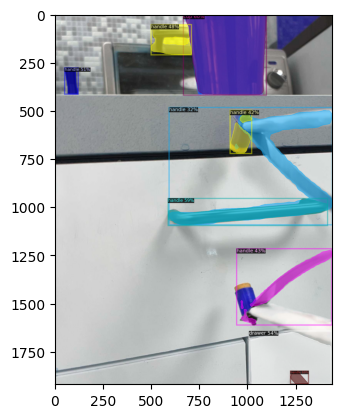

In [29]:
# Run model and show results
outputs = predictor(im)
print(im.shape)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [28]:
fields = outputs['instances'].get_fields()

In [31]:
print(fields['scores'])
print(fields['pred_classes'])

tensor([0.6491, 0.4727, 0.4450, 0.3890, 0.3375, 0.3370], device='cuda:0')
tensor([0, 2, 1, 2, 3, 3], device='cuda:0')


In [32]:
classes = metadata.thing_classes

In [35]:
class_names = []
class_idx = fields['pred_classes']
for i in range(class_idx):
    class_names.append(classes[i])

print(class_names)

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
# TODOS

# Lets say we have a preprocessor module that receives the dataloaders
# Traverses whole data directory
# Gets the images
# INitializes the Detic class
# And get all the embeddings